In [2]:
# -*- coding: utf-8 -*-

In [3]:
from __future__ import division
from IPython.display import Audio

In [4]:
%matplotlib inline
from IPython.display import display

In [5]:
# import io
# from nbformat import current

# def execute_notebook(nbfile):
    
#     with io.open(nbfile) as f:
#         nb = current.read(f, 'json')
    
#     ip = get_ipython()
    
#     for cell in nb.worksheets[0].cells:
#         if cell.cell_type != 'code':
#             continue
#         ip.run_cell(cell.input)

In [6]:
# execute_notebook("speechutils.ipynb")

In [7]:
%run "speechutils.py"

In [8]:
%run "viewutils.ipynb"

In [9]:
ch = callhome_eval_init("config.json", fast=False)

../../ZRTools/exp/callhome_train_20/matches/config0.80-0.90-0.80-50/master_graph.nodes
Loading prep state dictionary ...
Finished loading prep state dictionary ...
Finished ...
Finished - reading nodes ...
Processing line: 1
Finished - reading edges ...
Removing duplicates in pairs list
Set length: 19438 and List length: 43061
Generating vocabulary of English words ... 
Finished vocab ...
Generating initial belief over English translations
Processed 1 nodes
Generating similarity between nodes based on English translations ...
Finished generating similarity ...
Generating similarity between nodes based on English translations ...
Finished generating similarity ...
Processing line: 1
Processing line: 3001
Processing line: 6001
Processing line: 9001
Processing line: 12001
Processing line: 15001
Processing line: 18001
Total matches: 19438
matches with missing transcriptions: 0
matches with only sil, sp: 8986
Finished - evaluating 19438 pairs ...
Setting up eval data frame
Finished ...
Savi

In [10]:
df_zrt, cols_to_show = ch.gen_zrt_df()

# Analyse ZRT output

### Set up visualizations

In [11]:
pd.options.display.float_format = '{:,.3f}'.format

In [12]:
display(df_zrt.head(3))
display(df_zrt[cols_to_show].head(5))

,chid1,chid2,cnt_es_w_check,ES cont match,dur,en_w_cnt_count_sim_0,EN sim,en_w_count_sim_0,en_w_hgr_sim_0,ES phone edit sim,...,n1,n2,no_mtch,sil_only,uid1,uid2,ZRT,sim mixed,spk1,spk2
0,1,1,False,0,550,0,0.000,1,0.037,0.571,...,1,2,False,False,049.003,049.007,0.882,0.794,1.049.003,1.049.007
1,1,1,False,0,580,1,0.047,1,0.089,0.286,...,2,64,False,False,049.007,049.073,0.903,0.817,1.049.007,1.049.073
2,1,1,True,0,520,0,0.000,1,0.037,0.167,...,3,4,False,False,049.003,049.007,0.872,0.785,1.049.003,1.049.007


,n1,n2,ZRT,ES words n1,ES words n2,ES word match,ES phone edit sim,ES cont match,EN sim,sim mixed,spk1,spk2
0,1,2,0.882,LíNEAS Y ESTABA,QUE ESTáN,0,0.571,0,0.000,0.794,1.049.003,1.049.007
1,2,64,0.903,QUE ESTáN,EH sp A LO,0,0.286,0,0.047,0.817,1.049.007,1.049.073
2,3,4,0.872,MIRA ES QUE ESTOY,PUEDE DECIR SEXPERCIOS,0,0.167,0,0.000,0.785,1.049.003,1.049.007
3,5,6,0.883,AQUí EN UN TELéFONO,QUé NO APARECEN,0,0.364,0,0.000,0.795,1.049.003,1.049.044
4,6,126,0.861,QUé NO APARECEN,REFERENCIAS Y LOS DATOS,0,0.200,0,0.054,0.780,1.049.044,1.049.054


## Pairs discovered

### Filter Pairs

In [12]:
# Pairs with no matches in ES transcripts or only ['sil','sp'] matches
df_no_mtch_sil_only = df_zrt[(df_zrt['no_mtch'] == True) | (df_zrt['sil_only'] == True)]
# Pairs only ['sil','sp'] matches
df_sil_only = df_zrt[(df_zrt['sil_only'] == True)]
# Pairs with no matches in ES transcripts, but no ['sil','sp'] detected
df_no_mtch_not_sil = df_zrt[(df_zrt['no_mtch'] == True) & (df_zrt['sil_only'] == False)]

# Pairs with ES words found for both nodes
df_valid = df_zrt[(df_zrt['no_mtch'] == False) & (df_zrt['sil_only'] == False)]

# Filtering two files:
# df_valid = df_valid[df_valid.apply(lambda row: remove_invalid_files(row), axis=1)]
# df_valid = df_valid[df_valid['dur'] > 600]

# out_t = PrettyTable(["Description", "# of pairs"], hrules=True)
out_t = PrettyTable(["Description", "# of pairs"])
out_t.align['Description'] = 'r'
out_t.add_row(["Total pairs", len(df_zrt)])
out_t.add_row(["With sil, sp, or no matches", len(df_no_mtch_sil_only)])
out_t.add_row(["Pairs with speech segments and ES words", len(df_valid)])
print(out_t)
print(out_t.get_html_string())

+-----------------------------------------+------------+
|                             Description | # of pairs |
+-----------------------------------------+------------+
|                             Total pairs |   19438    |
|             With sil, sp, or no matches |    8986    |
| Pairs with speech segments and ES words |   10452    |
+-----------------------------------------+------------+
<table>
    <tr>
        <th>Description</th>
        <th># of pairs</th>
    </tr>
    <tr>
        <td>Total pairs</td>
        <td>19438</td>
    </tr>
    <tr>
        <td>With sil, sp, or no matches</td>
        <td>8986</td>
    </tr>
    <tr>
        <td>Pairs with speech segments and ES words</td>
        <td>10452</td>
    </tr>
</table>


## Histogram - ZRT values

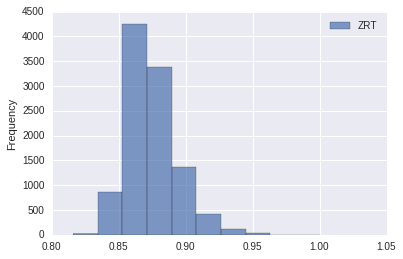

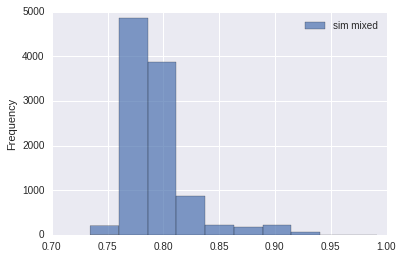

In [13]:
df_valid[['ZRT']].plot(kind='hist', alpha=0.7)
df_valid[['sim mixed']].plot(kind='hist', alpha=0.7)

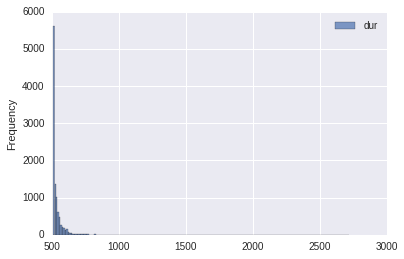

In [14]:
df_valid[['dur']].plot(kind='hist', alpha=0.7, bins=200)

## Correlation between DTW and other metrics

In [ ]:
display(df_valid[['ZRT', 'EN sim']].corr())
display(df_valid[['ZRT', 'ES phone edit sim']].corr())
display(df_valid[['ZRT', 'ES cont match']].corr())
display(df_valid[['ZRT', 'ES word match']].corr())
display(df_valid[['ES phone edit sim', 'ES word match']].corr())

# Long matches

In [15]:
long_dur_ms = 800
df_long_dur = df_valid[df_valid['dur'] >= long_dur_ms]
print("# of pairs with duration >= %dms : %d" % (long_dur_ms, len(df_long_dur)))
df_long_dur[cols_to_show].head(10)

# of pairs with duration >= 800ms : 63


,n1,n2,ZRT,ES words n1,ES words n2,ES word match,ES phone edit sim,ES cont match,EN sim,sim mixed,spk1,spk2
34,45,46,0.908,DIFíCILES POR EJEMPLO,FILóCTETES POR EJEMPLO P,1,0.857,1,0.092,0.826,1.049.007,1.049.014
3376,619,620,0.913,SIMPLEMENTE EXPONGO,SIMPLEMENTE,1,0.846,1,0.069,0.829,1.049.040,1.049.062
4624,1291,1292,0.925,sp AL sp DIECIOCHO,sil DEL DOCE AL DIECIOCHO,1,0.438,1,0.216,0.854,1.049.073,1.049.078
5118,1761,1762,0.933,ACTA DE BAUTISMO sil,ACTA DE BAUTISMO sil,1,1.000,1,0.119,0.852,1.049.142,1.049.152
5119,1763,1764,0.925,MI ACTA DE BAUTISMO,MI ACTA DE BAUTISMO,1,1.000,1,0.196,0.852,1.049.142,1.049.154
6506,2541,2542,0.943,BUENO sp sil,BICI,0,0.000,0,0.082,0.857,2.049.182,1.059.018
8476,3299,3300,0.934,sil NS AJá,CLASES NS sil,1,0.250,1,0.000,0.841,2.049.217,2.060.122
8571,3445,3446,0.932,Y YA LE HABLAMOS A,Y YA LE HABLAMOS,1,0.923,1,0.000,0.932,1.049.223,1.049.223
10251,5767,5768,0.929,RESPONDE sp,LA sp,0,0.333,0,0.000,0.836,2.050.034,2.050.048
11773,10443,10444,0.931,YO NO ME sp YO NO ME,YO NO ME sp YO NO ME,1,1.000,0,0.000,0.931,1.050.159,1.050.159


In [19]:
nodes_table = PrettyTable(["Node id", "Speech file", \
                           "Start time(ms)", \
                           "End time(ms)"])
for i in range(1,5):
    nodes_table.add_row([i, ch.node_dict[i].wav_fil+".wav", ch.node_dict[i].start, \
                        ch.node_dict[i].end])
print(nodes_table)
    

+---------+-------------+----------------+--------------+
| Node id | Speech file | Start time(ms) | End time(ms) |
+---------+-------------+----------------+--------------+
|    1    | 049.003.wav |      356       |     411      |
|    2    | 049.007.wav |      371       |     434      |
|    3    | 049.003.wav |       53       |     105      |
|    4    | 049.007.wav |      758       |     811      |
+---------+-------------+----------------+--------------+


In [16]:
display(Audio(ch.play_pair_wav(34)))
display(Audio(ch.play_pair_wav(5119)))

Playing evaluation pair id: 34
Pair text details
+---------+--------------------------+----------------------------------------------------+
| node id |      ES transcript       |                   EN translation                   |
+---------+--------------------------+----------------------------------------------------+
|    45   |  DIFíCILES POR EJEMPLO   | eh look i wanna tell you something there are some  |
|         |                          |    there are some things that are difficult for    |
|         |                          |  instance in english you cant say sexpercios how   |
|         |                          |                    you call it                     |
+---------+--------------------------+----------------------------------------------------+
|    46   | FILóCTETES POR EJEMPLO P | and mm how would you say how would would you spell |
|         |                          |           filoctetes for instance p h i            |
+---------+--------------------

Playing evaluation pair id: 5119
Pair text details
+---------+---------------------+----------------------------------------+
| node id |    ES transcript    |             EN translation             |
+---------+---------------------+----------------------------------------+
|   1763  | MI ACTA DE BAUTISMO | to tell them to send me my baptism act |
+---------+---------------------+----------------------------------------+
|   1764  | MI ACTA DE BAUTISMO |        my sacrament of baptism         |
+---------+---------------------+----------------------------------------+
Similarity metrics
+----------------------------------------+------------------+
|            Similarity Type             | Similarity Value |
+----------------------------------------+------------------+
|                  ZRT                   |      0.925       |
+----------------------------------------+------------------+
|         ES content* word match         |        1         |
+--------------------------------

In [ ]:
display(ch.play_node_wav(619))
display(ch.play_node_wav(620))
display(ch.play_node_wav(45))
display(ch.play_node_wav(46))

node_1_file = ch.play_node_wav(1761)
node_2_file = ch.play_node_wav(1762)
display(node_1_file)
display(node_2_file)
# display(ch.play_node_source_wav(76605))

In [ ]:
plot_dtw(node_1_file, node_2_file)

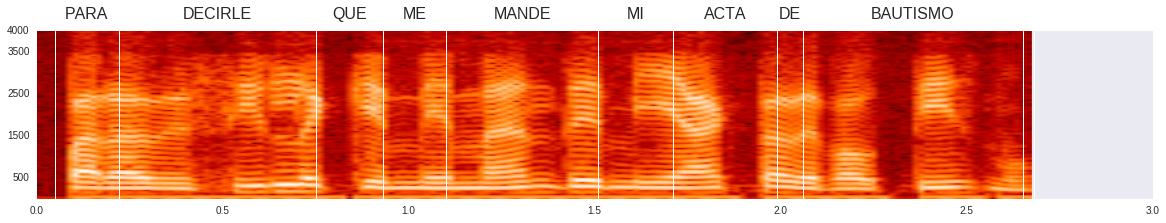

In [25]:
%run viewutils.ipynb
node_id = 1761

node_info = ch.node_dict[node_id]
wav_file = node_info.wav_fil
target_file = ch.file_info_dict[wav_file].target_file+".wav"
es_words = ch.es_words_dict[wav_file]
plot_name = "output/bautismo_1761.pdf"

plot_specgram_words(target_file, es_words, plot_name)

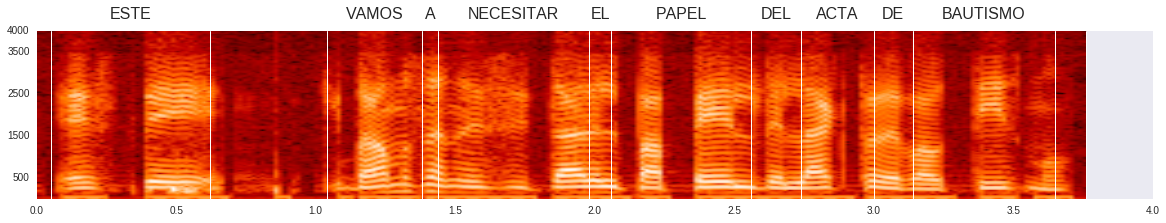

In [26]:
node_id = 1762

node_info = ch.node_dict[node_id]
wav_file = node_info.wav_fil
target_file = ch.file_info_dict[wav_file].target_file+".wav"
es_words = ch.es_words_dict[wav_file]
plot_name = "output/bautismo_1762.pdf"

plot_specgram_words(target_file, es_words, plot_name)

In [27]:
ch.play_pair_wav(5118)

Playing evaluation pair id: 5118
Pair text details
+---------+----------------------+-----------------------------------------------+
| node id |    ES transcript     |                 EN translation                |
+---------+----------------------+-----------------------------------------------+
|   1761  | ACTA DE BAUTISMO sil |     to tell them to send me my baptism act    |
+---------+----------------------+-----------------------------------------------+
|   1762  | ACTA DE BAUTISMO sil | we are going to need the sacrament of baptism |
|         |                      |                     paper                     |
+---------+----------------------+-----------------------------------------------+
Similarity metrics
+----------------------------------------+------------------+
|            Similarity Type             | Similarity Value |
+----------------------------------------+------------------+
|                  ZRT                   |      0.933       |
+-----------------

u'../../ZRTools/exp/callhome_train_20/matches/config0.80-0.90-0.80-50/wavs/p5118.wav'

DTW distance: 74.035992


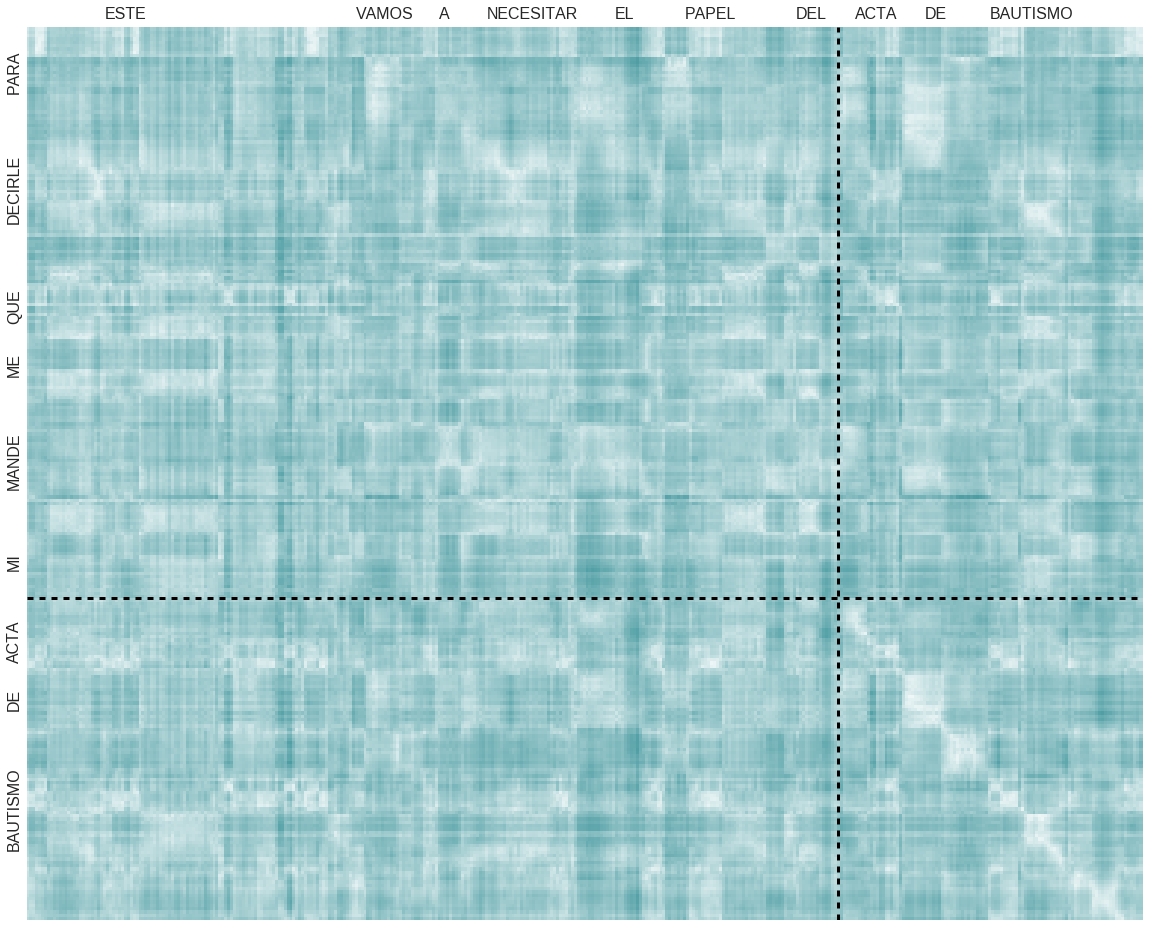

In [28]:
%run viewutils.ipynb

node_1 = ch.node_dict[1761]
node_2 = ch.node_dict[1762]

wav_1 = ch.file_info_dict[node_1.wav_fil].target_file+".wav"
wav_2 = ch.file_info_dict[node_2.wav_fil].target_file+".wav"

es_words_1 = ch.es_words_dict[node_1.wav_fil]
es_words_2 = ch.es_words_dict[node_2.wav_fil]
plot_name = "output/dtw_pair_1761_1762.pdf"
# print(wav_1, wav_2)
# print(es_words_1, es_words_2)

plot_dtw(wav_1, wav_2, es_words_1, es_words_2, plot_name)

In [ ]:
display(Audio(ch.play_pair_wav(19326)))

In [ ]:
node_1 = ch.node_dict[81217]
node_2 = ch.node_dict[81218]

wav_1 = ch.file_info_dict[node_1.wav_fil].target_file+".wav"
wav_2 = ch.file_info_dict[node_2.wav_fil].target_file+".wav"

es_words_1 = ch.es_words_dict[node_1.wav_fil]
es_words_2 = ch.es_words_dict[node_2.wav_fil]

# print(wav_1, wav_2)
# print(es_words_1, es_words_2)

plot_dtw(wav_1, wav_2, es_words_1, es_words_2)

In [ ]:
!soxi '../../corpora/callhome_es/out/049.142.wav'
!soxi '../../corpora/callhome_es/out/049.152.wav'

### Transcription error?

Pair id: 94 shows errors in transcriptions. The word "CONSTITUCIóN" has a duration greater than 1 sec in the transcription. This does not match the source audio file.

In [ ]:
display(ch.play_pair_wav(94))
display(ch.play_node_wav(70))
display(ch.play_node_wav(74, detail=True))
# display(ch.play_node_wav(209))
# display(ch.play_node_wav(210))
display(ch.play_node_source_wav(70))

In [ ]:
ch.play_node_source_wav(70)
ch.gen_segment_wav('../../corpora/callhome_es/out/050.048.wav', .12, 1, "t.wav")
IPython.display.Audio("t.wav")

In [ ]:
print(ch.calc_node_overlap(70, 74))

## Phoneme Similarity

For high DTW score pairs, the phone similarity score should be high as well.

Conversely, if phone similarity is very low, the pair may not be a good match.

### High phoneme score

In [ ]:
df_phone_score_hi = df_valid[(df_valid['ES phone edit sim'] >= 0.5)]
print("Pairs with high phoneme similarity score: %d" % len(df_phone_score_hi))

f, ax = plt.subplots(figsize=(10, 6))
df_phone_score_hi[['ZRT']].hist(ax=ax, alpha=0.7)
ax.set_xlabel('phoneme similarity score >= 0.5', fontsize=16)
# sns.rugplot(df_phone_score_0['ZRT'], color="b", ax=ax)
plt.tick_params(which='both', labelsize=12)
# plt.colorbar(aplot)

In [ ]:
df_phone_score_hi[cols_to_show].head(10)

In [ ]:
ch.play_pair_wav(10)

## Low phoneme score

In [ ]:
df_phone_score_0 = df_valid[(df_valid['ES phone edit sim'] == 0)]
print("Pairs with 0 phoneme similarity score: %d" % len(df_phone_score_0))

f, ax = plt.subplots(figsize=(10, 6))
df_phone_score_0[['ZRT']].hist(ax=ax, alpha=0.7)
ax.set_xlabel('phoneme similarity score = 0', fontsize=16)
# sns.rugplot(df_phone_score_0['ZRT'], color="b", ax=ax)
plt.tick_params(which='both', labelsize=12)
# plt.colorbar(aplot)

** Analysis:** The plot shows a lot of high DTW score pairs where there is no match in the phonemes

In [ ]:
df_phone_score_0_high_dtw = df_phone_score_0[df_phone_score_0['ZRT'] > 0.87]
print("Pairs with high DTW and 0 phoneme similarity score: %d" % len(df_phone_score_0_high_dtw))

display(df_phone_score_0_high_dtw[cols_to_show].head(3))
# ch.play_pair_wav(28)

In [ ]:
df_phone_score_0_en_score_0 = df_phone_score_0[df_phone_score_0['EN sim'] == 0]
print("Pairs with 0 phoneme score and 0 EN sim: %d" % len(df_phone_score_0_en_score_0))
# display(df_phone_score_0_en_score_0[cols_to_show][df_phone_score_0_en_score_0['ZRT'] < 0.82].head(3))
display(df_phone_score_0_en_score_0[cols_to_show].head(3))

df_phone_score_0_high_dtw_en_score_0 = df_phone_score_0_high_dtw[df_phone_score_0_high_dtw['EN sim'] == 0]
print("Pairs with high DTW and 0 phoneme score and 0 EN sim: %d" % len(df_phone_score_0_high_dtw_en_score_0))
display(df_phone_score_0_high_dtw_en_score_0[cols_to_show].head(3))

In [ ]:
# display(ch.play_pair_wav(594, detail=True))
display(ch.play_pair_wav(52, detail=False))
# display(ch.play_node_source_wav(131))

In [ ]:
ch.file_info_dict["049.156"].source_file

In [ ]:
# !soxi ../../corpora/callhome_es/out/006.183.wav
# !play ../../corpora/callhome_es/out/006.183.wav trim 1.24
# IPython.display.Audio("../../corpora/callhome_es/out/tmp/sp_0731_1.wav")

### Conclusion

**Pairs with high DTW and 0 phoneme and 0 EN word similarity indicate transcription errors or coding errors**


**Need to investigate**

### High Phoneme similarity

In [ ]:
# df_phone_score_hi = df_valid[(df_valid['ES phone edit sim'] >= 0.5)]
# print("Pairs with high phoneme similarity score: %d" % len(df_phone_score_hi))

f, ax = plt.subplots(figsize=(10, 6))
df_valid['ZRT'].hist(ax=ax, alpha=0.3)
df_phone_score_hi['ZRT'].hist(ax=ax, alpha=0.7)
ax.set_xlabel('phoneme similarity score > 0.5', fontsize=16)
# sns.rugplot(df_phone_score_0['ZRT'], color="b", ax=ax)
plt.tick_params(which='both', labelsize=12)
# plt.colorbar(aplot)

In [ ]:
df_phone_score_hi_en_score_0 = df_phone_score_hi[(df_phone_score_hi['EN sim'] == 0) & \
                                                (df_phone_score_hi['spk1'] != df_phone_score_hi['spk2'])]
print("Pairs with high phoneme score and 0 EN sim: %d" % len(df_phone_score_hi_en_score_0))

df_phone_score_hi_en_score_0[cols_to_show].head(5)

In [ ]:
ch.play_pair_wav(70)

## High DTW score, Low EN translation similarity

These are expected to be phonetically similary but semantically different pairs.

**Label Spreading** should help **lower** the DTW score

In [ ]:
df_valid['ZRT'][(df_valid['EN sim'] == 0)].hist()
print(len(df_valid['ZRT'][(df_valid['EN sim'] == 0)]))

In [ ]:
df_high_dtw_0_en = df_valid[(df_valid['ZRT'] > 0.87) & (df_valid['EN sim'] >= 0.2) & \
                                                (df_valid['spk1'] != df_valid['spk2'])]

In [ ]:
print("Pairs with high DTW annd 0 EN sim: %d" % len(df_high_dtw_0_en))
df_high_dtw_0_en[cols_to_show].head(5)

In [ ]:
display(ch.play_pair_wav(0, detail=True))

In [ ]:
# !play ../../corpora/callhome_es/out/001.202.wav trim .75 =.99

## Low DTW score, High EN translation similarity

These are expected to be semantically similar but phonetically not very similar.

**Label Spreading** should help **increase** the DTW score

In [ ]:
df_valid['ZRT'][(df_valid['EN sim'] >= 0.2)].hist()

In [ ]:
df_low_dtw_high_en = df_valid[(df_valid['ZRT'] < 0.88) & (df_valid['EN sim'] >= 0.2)]

In [ ]:
print("Pairs with high DTW annd 0 EN sim: %d" % len(df_low_dtw_high_en))
df_low_dtw_high_en[cols_to_show].tail()

In [ ]:
display(Audio(ch.play_pair_wav(19326, detail=True)))

## Precision / Recall

In [ ]:
df_valid[cols_to_show].head()

In [ ]:
ch.play_pair_wav(1)

In [ ]:
ch.eval_precision_recall()

In [ ]:
ch.eval_precision_recall(sim_col='sim mixed')

In [ ]:
ch.plot_precision_recall(both=True)

## Cross-utterance matches

In [ ]:
set_speakers_calls = set()
spk1_ids = [s.rsplit('.', 1)[0] for s in df_valid['spk1'].values]
spk2_ids = [s.rsplit('.', 1)[0] for s in df_valid['spk2'].values]
set_speakers_calls |= set(spk1_ids)
set_speakers_calls |= set(spk2_ids)

num_speakers = len(set_speakers_calls)
cross_spk_counts = np.zeros((num_speakers, num_speakers), dtype=np.int)
label2i = {k:i for i, k in enumerate(set_speakers_calls)}
i2label = {i:k for i, k in enumerate(set_speakers_calls)}

for spk1, spk2 in zip(spk1_ids, spk2_ids):
    if spk1 != spk2:
        cross_spk_counts[max(label2i[spk1], label2i[spk2]), min(label2i[spk1], label2i[spk2])] += 1
        cross_spk_counts[min(label2i[spk1], label2i[spk2]), max(label2i[spk1], label2i[spk2])] += 1
    else:
        cross_spk_counts[label2i[spk1], label2i[spk2]] += 1
        pass

print("Total speakers: %d" % num_speakers)

In [ ]:
f, ax = plt.subplots(figsize=(8, 8))
cmap = sns.diverging_palette(220, 10, as_cmap=True)

with sns.axes_style("white"):
    ax = sns.heatmap(cross_spk_counts, square=True, annot=False, \
                 fmt="d", linewidths=.5, cbar=False, xticklabels=2, yticklabels=2)
ax.xaxis.tick_top()

In [ ]:
# df_valid.columns
df_cross_spkr = df_valid[df_valid.apply(lambda row: row['spk1'].rsplit('.', 1)[0] != \
                                   row['spk2'].rsplit('.', 1)[0], \
                                   axis=1)]
print("# of cross-speaker pairs: %d" % (len(df_cross_spkr)))
display(df_cross_spkr[cols_to_show].head(5))
#df_cross_spkr['ZRT'].hist()

In [ ]:
df_cross_spkr_bad_zrt_good_en = df_cross_spkr[(df_cross_spkr['ZRT'] <= 0.87)\
                                              & (df_cross_spkr['EN sim'] > 0.2)]
print("# of cross-speaker pairs: %d" % (len(df_cross_spkr_bad_zrt_good_en)))
display(df_cross_spkr_bad_zrt_good_en[cols_to_show].head(10))

In [ ]:
display(Audio(ch.play_pair_wav(16848)))

## Speakers/utterances with most matches

In [ ]:
df_spkr_matches = df_valid.apply(lambda row: row['spk1'].rsplit('.', 1)[0] != \
                                   row['spk2'].rsplit('.', 1)[0], \
                                   axis=1)
print("# of cross-speaker pairs: %d" % (len(df_cross_spkr)))
display(df_cross_spkr[cols_to_show].head(3))
df_cross_spkr['ZRT'].hist()

## s

## Label Spreading - speech pair similarity score update using English translations

In [ ]:
ch.label_prop_edges.label_spread(ch.en_w_hgr_sim_0)

In [ ]:
print(ch.label_prop_edges.belief_0[1])
print(ch.label_prop_edges.belief_n[1])
print(ch.en_w_hgr_sim_0[1], ch.en_w_hgr_sim_0[2])

In [ ]:
df_valid[cols_to_show].sort_values(['ZRT'], ascending=False)

In [ ]:
display(ch.play_pair_wav(84, detail=True))

In [ ]:
(0.9 * 0.8) + (0.1 * 0.7)

In [ ]:
df_valid.columns

In [ ]:
sns.jointplot(x='ZRT', y='ES cont match', data=df_valid, kind='kde')

In [ ]:
df_valid.columns

In [ ]:
%run viewutils.ipynb
plot_hist_dtw(df_valid)

In [ ]:
%%timeit -n1 -r1
ch_eval.label_prop_en_words.label_spread(ch_eval.edges_dict)
print(ch_eval.edges_dict[1])
print(ch_eval.en_w_belief[1])
print(ch_eval.en_w_belief[2])
print(ch_eval.label_prop_en_words.belief_0[1])
print(ch_eval.label_prop_en_words.belief_n[1])

print(len(ch_eval.en_vocab))
print(sorted(ch_eval.en_words_stats.items(), reverse=True, key= lambda x: x[1])[:5])
print(ch_eval.en_w_sim_0[1])
print(ch_eval.label_prop_en_words.belief_0[1])
print(ch_eval.label_prop_en_words.belief_n[1])
print(ch_eval.label_prop_en_words.belief_0[2])
print(ch_eval.label_prop_en_words.belief_n[2])